In [1]:
# Install dependencies (this is mostly for Google Colab, as the other dependences are available by default in Colab)
try:
  import datasets, evaluate, accelerate
  import gradio as gr
except ModuleNotFoundError:
  !pip install -U datasets evaluate accelerate gradio # -U stands for "upgrade" so we'll get the latest version by default
  import datasets, evaluate, accelerate
  import gradio as gr

import random

import numpy as np
import pandas as pd

import torch
import transformers

print(f"Using transformers version: {transformers.__version__}")
print(f"Using datasets version: {datasets.__version__}")
print(f"Using torch version: {torch.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.6 MB/s eta 0:00:00
Using transformers version: 4.56.0
Using datasets version: 4.0.0
Using torch version: 2.8.0+cu126


In [2]:
# Load the dataset from Hugging Face Hub
dataset = datasets.load_dataset(path="mrdbourke/learn_hf_food_not_food_image_captions")

# Inspect the dataset
dataset

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/11.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/250 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 250
    })
})

In [3]:
dataset.column_names

{'train': ['text', 'label']}

In [4]:
dataset["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 250
})

In [5]:
dataset.get("train")[0]

{'text': 'Creamy cauliflower curry with garlic naan, featuring tender cauliflower in a rich sauce with cream and spices, served with garlic naan bread.',
 'label': 'food'}

In [6]:
import random

random_indexes = random.sample(range(len(dataset["train"])), 5)
random_samples = dataset["train"][random_indexes]

for item in zip(random_samples["text"], random_samples["label"]):
    print(f"Text: {item[0]} | label: {item[1]}")

Text: Microscope set up on a table | label: not_food
Text: A close-up shot of a ripe and juicy peach with a sprinkle of cinnamon | label: food
Text: Margherita pizza topped with fresh basil leaves and juicy tomatoes | label: food
Text: Potted plant adding greenery to a windowsill | label: not_food
Text: Close-up of a sushi roll with avocado, cucumber, and salmon. | label: food


In [7]:
# Get unique label values
dataset["train"].unique("label")

['food', 'not_food']

In [8]:
# Check number of each label
from collections import Counter

Counter(dataset["train"]["label"])

Counter({'food': 125, 'not_food': 125})

In [9]:
# Turn our dataset into a DataFrame and get a random sample
food_not_food_df = pd.DataFrame(dataset["train"])
food_not_food_df.sample(7)

,text,label
138,Grapefruit slides on top of yoghurt in a green...,food
42,Set of tongs stored in a drawer,not_food
74,Set of paintbrushes stored in a jar,not_food
43,Bowl of sashimi with thin slices of raw fish.,food
81,"Working from home at her desk, a woman deals w...",not_food
153,"Pizza with a meat lover's theme, including sau...",food
208,"Brushing her cat's fur in her bedroom, a young...",not_food


In [10]:
# Get the value counts of the label column
food_not_food_df["label"].value_counts()

,count
label,
food,125
not_food,125


In [11]:
# Create mapping from id2label and label2id
id2label = {0: "not_food", 1: "food"}
label2id = {"not_food": 0, "food": 1}

print(f"Label to ID mapping: {label2id}")
print(f"ID to Label mapping: {id2label}")

Label to ID mapping: {'not_food': 0, 'food': 1}
ID to Label mapping: {0: 'not_food', 1: 'food'}


In [12]:
# Create mappings programmatically from dataset
id2label = {idx: label for idx, label in enumerate(dataset["train"].unique("label")[::-1])} # reverse sort list to have "not_food" first
label2id = {label: idx for idx, label in id2label.items()}

print(f"Label to ID mapping: {label2id}")
print(f"ID to Label mapping: {id2label}")

Label to ID mapping: {'not_food': 0, 'food': 1}
ID to Label mapping: {0: 'not_food', 1: 'food'}


In [13]:
# Turn labels into 0 or 1 (e.g. 0 for "not_food", 1 for "food")
def map_labels_to_number(example):
  example["label"] = label2id[example["label"]]
  return example

example_sample = {"text": "This is a sentence about my favourite food: honey.", "label": "food"}

# Test the function
map_labels_to_number(example_sample)

{'text': 'This is a sentence about my favourite food: honey.', 'label': 1}

In [14]:
dataset = dataset["train"].map(map_labels_to_number)
dataset[:5]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

{'text': ['Creamy cauliflower curry with garlic naan, featuring tender cauliflower in a rich sauce with cream and spices, served with garlic naan bread.',
  'Set of books stacked on a desk',
  'Watching TV together, a family has their dog stretched out on the floor',
  'Wooden dresser with a mirror reflecting the room',
  'Lawn mower stored in a shed'],
 'label': [1, 0, 0, 0, 0]}

In [15]:
dataset.shuffle()[:5]

{'text': ['Sushi with unique toppings like seared tuna or eel sauce.',
  'Stainless steel refrigerator with a convenient water dispenser',
  'Microwave oven ready for use on a kitchen counter',
  'Mailbox standing by a front door',
  'A boy building a fort in the living room with his curious cat watching'],
 'label': [1, 0, 0, 0, 0]}

In [16]:
dataset = dataset.train_test_split(test_size=0.2, seed=42)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 50
    })
})

In [17]:
random_idx_train = random.randint(0, len(dataset["train"]))
random_sample_train = dataset["train"][random_idx_train]

random_idx_test = random.randint(0, len(dataset["test"]))
random_sample_test = dataset["test"][random_idx_test]

print(f"[INFO] Random sample from training dataset:")
print(f"Text: {random_sample_train['text']}\nLabel: {random_sample_train['label']} ({id2label[random_sample_train['label']]})\n")
print(f"[INFO] Random sample from testing dataset:")
print(f"Text: {random_sample_test['text']}\nLabel: {random_sample_test['label']} ({id2label[random_sample_test['label']]})")

[INFO] Random sample from training dataset:
Text: Set of knitting needles with yarn waiting to be knitted
Label: 0 (not_food)

[INFO] Random sample from testing dataset:
Text: A slice of pepperoni pizza with a layer of melted cheese
Label: 1 (food)


In [18]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path="distilbert/distilbert-base-uncased",
                                          use_fast=True) # uses fast tokenization (backed by tokenziers library and implemented in Rust) by default, if not available will default to Python implementation

tokenizer

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [19]:
# Test out tokenizer
tokenizer("I love pizza")

{'input_ids': [101, 1045, 2293, 10733, 102], 'attention_mask': [1, 1, 1, 1, 1]}

In [20]:
# Get the length of the vocabulary
length_of_tokenizer_vocab = len(tokenizer.vocab)
print(f"Length of tokenizer vocabulary: {length_of_tokenizer_vocab}")

# Get the maximum sequence length the tokenizer can handle
max_tokenizer_input_sequence_length = tokenizer.model_max_length
print(f"Max tokenizer input sequence length: {max_tokenizer_input_sequence_length}")

Length of tokenizer vocabulary: 30522
Max tokenizer input sequence length: 512


In [21]:
tokenizer.vocab["dylan"]

7758

In [22]:
tokenizer.convert_ids_to_tokens(tokenizer("akash").input_ids)

['[CLS]', 'aka', '##sh', '[SEP]']

In [23]:
def tokenize_text(examples):
    """
    Tokenize given example text and return the tokenized text.
    """
    return tokenizer(examples["text"],
                     padding=True, # pad short sequences to longest sequence in the batch
                     truncation=True) # truncate long sequences to the maximum length the model can handle

In [24]:
example_sample_2 = {"text": "I love pizza", "label": 1}

# Test the function
tokenize_text(example_sample_2)

{'input_ids': [101, 1045, 2293, 10733, 102], 'attention_mask': [1, 1, 1, 1, 1]}

In [25]:
# Map our tokenize_text function to the dataset
tokenized_dataset = dataset.map(function=tokenize_text,
                                batched=True, # set batched=True to operate across batches of examples rather than only single examples
                                batch_size=1000) # defaults to 1000, can be increased if you have a large dataset

tokenized_dataset

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 50
    })
})

In [26]:
# Get two samples from the tokenized dataset
train_tokenized_sample = tokenized_dataset["train"][0]
test_tokenized_sample = tokenized_dataset["test"][0]

for key in train_tokenized_sample.keys():
    print(f"[INFO] Key: {key}")
    print(f"Train sample: {train_tokenized_sample[key]}")
    print(f"Test sample: {test_tokenized_sample[key]}")
    print("")

[INFO] Key: text
Train sample: Set of headphones placed on a desk
Test sample: A slice of pepperoni pizza with a layer of melted cheese

[INFO] Key: label
Train sample: 0
Test sample: 1

[INFO] Key: input_ids
Train sample: [101, 2275, 1997, 2132, 19093, 2872, 2006, 1037, 4624, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test sample: [101, 1037, 14704, 1997, 11565, 10698, 10733, 2007, 1037, 6741, 1997, 12501, 8808, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[INFO] Key: attention_mask
Train sample: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test sample: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]



In [27]:
import evaluate
import numpy as np
from typing import Tuple

accuracy_metric = evaluate.load("accuracy")

def compute_accuracy(predictions_and_labels: Tuple[np.array, np.array]):
  """
  Computes the accuracy of a model by comparing the predictions and labels.
  """
  predictions, labels = predictions_and_labels

  # Get highest prediction probability of each prediction if predictions are probabilities
  if len(predictions.shape) >= 2:
    predictions = np.argmax(predictions, axis=1)

  return accuracy_metric.compute(predictions=predictions, references=labels)

In [28]:
# Create example list of predictions and labels
example_predictions_all_correct = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
example_predictions_one_wrong = np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
example_labels = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Test the function
print(f"Accuracy when all predictions are correct: {compute_accuracy((example_predictions_all_correct, example_labels))}")
print(f"Accuracy when one prediction is wrong: {compute_accuracy((example_predictions_one_wrong, example_labels))}")

Accuracy when all predictions are correct: {'accuracy': 1.0}
Accuracy when one prediction is wrong: {'accuracy': 0.9}


In [29]:
# Get id and label mappings
print(f"id2label: {id2label}")
print(f"label2id: {label2id}")

id2label: {0: 'not_food', 1: 'food'}
label2id: {'not_food': 0, 'food': 1}


In [30]:
from transformers import AutoModelForSequenceClassification

# Setup model for fine-tuning with classification head (top layers of network)
model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="distilbert/distilbert-base-uncased",
    num_labels=2, # can customize this to the number of classes in your dataset
    id2label=id2label, # mappings from class IDs to the class labels (for classification tasks)
    label2id=label2id
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
tokenized_dataset["train"][0]

{'text': 'Set of headphones placed on a desk',
 'label': 0,
 'input_ids': [101,
  2275,
  1997,
  2132,
  19093,
  2872,
  2006,
  1037,
  4624,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

In [32]:
def count_params(model):
    """
    Count the parameters of a PyTorch model.
    """
    trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_parameters = sum(p.numel() for p in model.parameters())

    return {"trainable_parameters": trainable_parameters, "total_parameters": total_parameters}

# Count the parameters of the model
count_params(model)

{'trainable_parameters': 66955010, 'total_parameters': 66955010}

In [33]:
 # Create model output directory
from pathlib import Path

# Create models directory
models_dir = Path("models")
models_dir.mkdir(exist_ok=True)

# Create model save name
model_save_name = "learn_hf_food_not_food_text_classifier-distilbert-base-uncased"

# Create model save path
model_save_dir = Path(models_dir, model_save_name)

model_save_dir

PosixPath('models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased')

In [34]:
model.parameters()

<generator object Module.parameters at 0x7d09006d0c80>

In [35]:
from transformers import TrainingArguments

print(f"[INFO] Saving model checkpoints to: {model_save_dir}")

# Create training arguments
training_args = TrainingArguments(
    output_dir=model_save_dir,
    learning_rate=0.0001,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    eval_strategy="epoch", # was previously "evaluation_strategy"
    save_strategy="epoch",
    save_total_limit=3, # limit the total amount of save checkpoints (so we don't save num_epochs checkpoints)
    use_cpu=False, # set to False by default, will use CUDA GPU or MPS device if available
    seed=42, # set to 42 by default for reproducibility
    load_best_model_at_end=True, # load the best model when finished training
    logging_strategy="epoch", # log training results every epoch
    report_to="none", # optional: log experiments to Weights & Biases/other similar experimenting tracking services (we'll turn this off for now)
    hub_private_repo=False # optional: make the uploaded model private (defaults to False)
)

# Optional: Print out training_args to inspect (warning, it is quite a long output)
# training_args

[INFO] Saving model checkpoints to: models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased


In [36]:
from transformers import Trainer

# Setup Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    # Note: the 'tokenizer' parameter will be changed to 'processing_class' in Transformers v5.0.0
    tokenizer=tokenizer, # Pass tokenizer to the Trainer for dynamic padding (padding as the training happens) (see "data_collator" in the Trainer docs)
    compute_metrics=compute_accuracy
)

/tmp/ipython-input-1457455194.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [37]:
results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.487000,0.186691,0.980000
2,0.106800,0.014895,1.000000
3,0.010800,0.003882,1.000000
4,0.003300,0.001730,1.000000
5,0.001700,0.001093,1.000000
6,0.001200,0.000840,1.000000
7,0.001000,0.000713,1.000000
8,0.000900,0.000647,1.000000
9,0.000800,0.000614,1.000000
10,0.000800,0.000603,1.000000


In [38]:
for key, value in results.metrics.items():
    print(f"{key}: {value}")

train_runtime: 65.5335
train_samples_per_second: 30.519
train_steps_per_second: 1.068
total_flos: 18110777160000.0
train_loss: 0.061430315959400364
epoch: 10.0


In [39]:
 # Save model
print(f"[INFO] Saving model to {model_save_dir}")
trainer.save_model(output_dir=model_save_dir)

[INFO] Saving model to models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased


In [40]:
# Get training history
trainer_history_all = trainer.state.log_history
trainer_history_metrics = trainer_history_all[:-1]
trainer_history_training_time = trainer_history_all[-1] # this is the same value as results.metrics from above

# View the first 4 metrics from the training history
trainer_history_metrics[:4]

[{'loss': 0.487,
  'grad_norm': 2.8284707069396973,
  'learning_rate': 9.142857142857143e-05,
  'epoch': 1.0,
  'step': 7},
 {'eval_loss': 0.18669073283672333,
  'eval_accuracy': 0.98,
  'eval_runtime': 0.109,
  'eval_samples_per_second': 458.572,
  'eval_steps_per_second': 18.343,
  'epoch': 1.0,
  'step': 7},
 {'loss': 0.1068,
  'grad_norm': 0.27440446615219116,
  'learning_rate': 8.142857142857143e-05,
  'epoch': 2.0,
  'step': 14},
 {'eval_loss': 0.014894885942339897,
  'eval_accuracy': 1.0,
  'eval_runtime': 0.0702,
  'eval_samples_per_second': 712.704,
  'eval_steps_per_second': 28.508,
  'epoch': 2.0,
  'step': 14}]

In [41]:
import pprint # import pretty print for nice printing of lists

# Extract training and evaluation metrics
trainer_history_training_set = []
trainer_history_eval_set = []

# Loop through metrics and filter for training and eval metrics
for item in trainer_history_metrics:
    item_keys = list(item.keys())
    # Check to see if "eval" is in the keys of the item
    if any("eval" in item for item in item_keys):
        trainer_history_eval_set.append(item)
    else:
        trainer_history_training_set.append(item)

# Show the first two items in each metric set
print(f"[INFO] First two items in training set:")
pprint.pprint(trainer_history_training_set[:2])

print(f"\n[INFO] First two items in evaluation set:")
pprint.pprint(trainer_history_eval_set[:2])

[INFO] First two items in training set:
[{'epoch': 1.0,
  'grad_norm': 2.8284707069396973,
  'learning_rate': 9.142857142857143e-05,
  'loss': 0.487,
  'step': 7},
 {'epoch': 2.0,
  'grad_norm': 0.27440446615219116,
  'learning_rate': 8.142857142857143e-05,
  'loss': 0.1068,
  'step': 14}]

[INFO] First two items in evaluation set:
[{'epoch': 1.0,
  'eval_accuracy': 0.98,
  'eval_loss': 0.18669073283672333,
  'eval_runtime': 0.109,
  'eval_samples_per_second': 458.572,
  'eval_steps_per_second': 18.343,
  'step': 7},
 {'epoch': 2.0,
  'eval_accuracy': 1.0,
  'eval_loss': 0.014894885942339897,
  'eval_runtime': 0.0702,
  'eval_samples_per_second': 712.704,
  'eval_steps_per_second': 28.508,
  'step': 14}]


In [42]:
# Create pandas DataFrames for the training and evaluation metrics
trainer_history_training_df = pd.DataFrame(trainer_history_training_set)
trainer_history_eval_df = pd.DataFrame(trainer_history_eval_set)

trainer_history_training_df.head()

,loss,grad_norm,learning_rate,epoch,step
0,0.4870,2.828471,0.000091,1.0,7
1,0.1068,0.274404,0.000081,2.0,14
2,0.0108,0.088059,0.000071,3.0,21
3,0.0033,0.056602,0.000061,4.0,28
4,0.0017,0.028907,0.000051,5.0,35


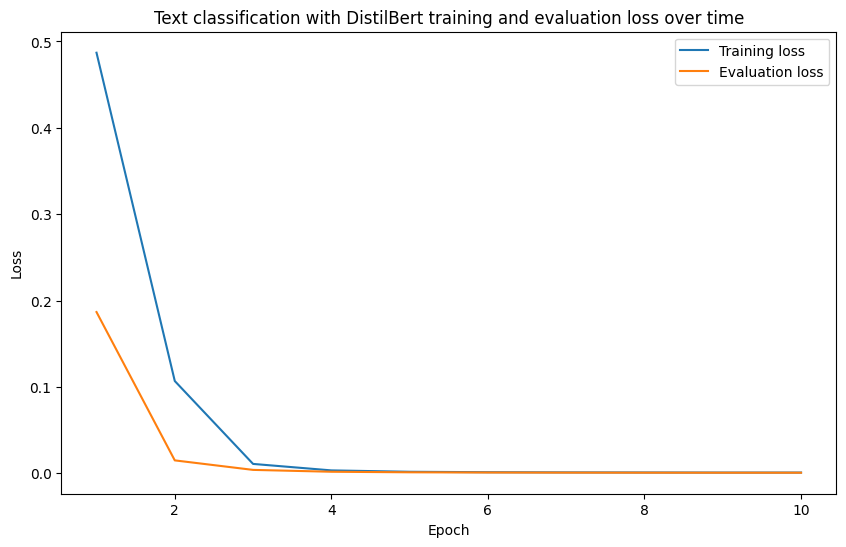

In [43]:
# Plot training and evaluation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(trainer_history_training_df["epoch"], trainer_history_training_df["loss"], label="Training loss")
plt.plot(trainer_history_eval_df["epoch"], trainer_history_eval_df["eval_loss"], label="Evaluation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Text classification with DistilBert training and evaluation loss over time")
plt.legend()
plt.show()

In [44]:
# Perform predictions on the test set
predictions_all = trainer.predict(tokenized_dataset["test"])
prediction_values = predictions_all.predictions
prediction_metrics = predictions_all.metrics

print(f"[INFO] Prediction metrics on the test data:")
prediction_metrics

[INFO] Prediction metrics on the test data:


{'test_loss': 0.000602958956733346,
 'test_accuracy': 1.0,
 'test_runtime': 0.0986,
 'test_samples_per_second': 507.176,
 'test_steps_per_second': 20.287}

In [45]:
import torch
from sklearn.metrics import accuracy_score

# 1. Get prediction probabilities (this is optional, could get the same results with step 2 onwards)
pred_probs = torch.softmax(torch.tensor(prediction_values), dim=1)

# 2. Get the predicted labels
pred_labels = torch.argmax(pred_probs, dim=1)

# 3. Get the true labels
true_labels = dataset["test"]["label"]

# 4. Compare predicted labels to true labels to get the test accuracy
test_accuracy = accuracy_score(y_true=true_labels,
                               y_pred=pred_labels)

print(f"[INFO] Test accuracy: {test_accuracy*100}%")

[INFO] Test accuracy: 100.0%


In [46]:
# Make a DataFrame of test predictions
test_predictions_df = pd.DataFrame({
    "text": dataset["test"]["text"],
    "true_label": true_labels,
    "pred_label": pred_labels,
    "pred_prob": torch.max(pred_probs, dim=1).values
})

test_predictions_df.head()

,text,true_label,pred_label,pred_prob
0,A slice of pepperoni pizza with a layer of mel...,1,1,0.999374
1,Red brick fireplace with a mantel serving as a...,0,0,0.999408
2,A bowl of sliced bell peppers with a sprinkle ...,1,1,0.999385
3,Set of mugs hanging on a hook,0,0,0.999465
4,Standing floor lamp providing light next to an...,0,0,0.999443


In [47]:
# Show 10 examples with low prediction probability
test_predictions_df.sort_values("pred_prob", ascending=True).head(10)

,text,true_label,pred_label,pred_prob
40,A bowl of cherries with a sprig of mint for ga...,1,1,0.999203
11,A close-up shot of a cheesy pizza slice being ...,1,1,0.999341
42,"Boxes of apples, pears, pineapple, manadrins a...",1,1,0.999350
14,Two handfuls of bananas in a fruit bowl with g...,1,1,0.999357
26,A fruit platter with a variety of exotic fruit...,1,1,0.999367
20,"Pizza with a seafood theme, featuring toppings...",1,1,0.999370
31,Crunchy sushi roll with tempura flakes or pank...,1,1,0.999371
41,"Sushi with a spicy kick, featuring jalapeno pe...",1,1,0.999371
0,A slice of pepperoni pizza with a layer of mel...,1,1,0.999374
46,A bowl of sliced kiwi with a sprinkle of sugar...,1,1,0.999376


In [48]:
# Setup local model path
local_model_path = "models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased"

In [49]:
def set_device():
    """
    Set device to CUDA if available, else MPS (Mac), else CPU.

    This defaults to using the best available device (usually).
    """
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    return device

DEVICE = set_device()
print(f"[INFO] Using device: {DEVICE}")

[INFO] Using device: cuda


In [50]:
import torch
from transformers import pipeline

# Set the batch size for predictions
BATCH_SIZE = 32

# Create an instance of transformers.pipeline
food_not_food_classifier = pipeline(task="text-classification", # we can use this because our model is an instance of AutoModelForSequenceClassification
                                    model=local_model_path, # could also pass in huggingface_model_path
                                    device=DEVICE, # set the target device
                                    top_k=1, # only return the top predicted value
                                    batch_size=BATCH_SIZE) # perform predictions on up to BATCH_SIZE number of samples at a time

food_not_food_classifier

Device set to use cuda


In [51]:
# Test the model on some more example text
sample_text_not_food = "A yellow tractor driving over the hill"
food_not_food_classifier(sample_text_not_food)

[[{'label': 'not_food', 'score': 0.9994266033172607}]]

In [52]:
# Test the model on some more example text
sample_text_not_food = "A yellow tractor driving over the hill"
food_not_food_classifier(sample_text_not_food)

[[{'label': 'not_food', 'score': 0.9994266033172607}]]

In [53]:
# Create a list of sentences to make predictions on
sentences = [
    "I whipped up a fresh batch of code, but it seems to have a syntax error.",
    "We need to marinate these ideas overnight before presenting them to the client.",
    "The new software is definitely a spicy upgrade, taking some time to get used to.",
    "Her social media post was the perfect recipe for a viral sensation.",
    "He served up a rebuttal full of facts, leaving his opponent speechless.",
    "The team needs to simmer down a bit before tackling the next challenge.",
    "The presentation was a delicious blend of humor and information, keeping the audience engaged.",
    "A beautiful array of fake wax foods (shokuhin sampuru) in the front of a Japanese restaurant.",
    "Daniel Bourke is really cool :D",
    "My favoruite food is biltong!"
]

food_not_food_classifier(sentences)

[[{'label': 'not_food', 'score': 0.9955659508705139}],
 [{'label': 'not_food', 'score': 0.9981186985969543}],
 [{'label': 'not_food', 'score': 0.9982888102531433}],
 [{'label': 'not_food', 'score': 0.9976828098297119}],
 [{'label': 'not_food', 'score': 0.9951263666152954}],
 [{'label': 'not_food', 'score': 0.9976600408554077}],
 [{'label': 'not_food', 'score': 0.9800300002098083}],
 [{'label': 'food', 'score': 0.9980765581130981}],
 [{'label': 'not_food', 'score': 0.9989392161369324}],
 [{'label': 'not_food', 'score': 0.997445821762085}]]

In [54]:
import time

# Create 1000 sentences
sentences_1000 = sentences * 100

# Time how long it takes to make predictions on all sentences (one at a time)
print(f"[INFO] Number of sentences: {len(sentences_1000)}")
start_time_one_at_a_time = time.time()
for sentence in sentences_1000:
    # Make a prediction on each sentence one at a time
    food_not_food_classifier(sentence)
end_time_one_at_a_time = time.time()

print(f"[INFO] Time taken for one at a time prediction: {end_time_one_at_a_time - start_time_one_at_a_time} seconds")
print(f"[INFO] Avg inference time per sentence: {(end_time_one_at_a_time - start_time_one_at_a_time) / len(sentences_1000)} seconds")

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


[INFO] Number of sentences: 1000
[INFO] Time taken for one at a time prediction: 9.57362699508667 seconds
[INFO] Avg inference time per sentence: 0.00957362699508667 seconds


In [55]:
for i in [10, 100, 1000, 10_000]:
    sentences_big = sentences * i
    print(f"[INFO] Number of sentences: {len(sentences_big)}")

    start_time = time.time()
    # Predict on all sentences in batches
    food_not_food_classifier(sentences_big)
    end_time = time.time()

    print(f"[INFO] Inference time for {len(sentences_big)} sentences: {round(end_time - start_time, 5)} seconds.")
    print(f"[INFO] Avg inference time per sentence: {round((end_time - start_time) / len(sentences_big), 8)} seconds.")
    print()

[INFO] Number of sentences: 100
[INFO] Inference time for 100 sentences: 0.08272 seconds.
[INFO] Avg inference time per sentence: 0.00082716 seconds.

[INFO] Number of sentences: 1000
[INFO] Inference time for 1000 sentences: 0.95919 seconds.
[INFO] Avg inference time per sentence: 0.00095919 seconds.

[INFO] Number of sentences: 10000
[INFO] Inference time for 10000 sentences: 9.06869 seconds.
[INFO] Avg inference time per sentence: 0.00090687 seconds.

[INFO] Number of sentences: 100000
[INFO] Inference time for 100000 sentences: 90.91667 seconds.
[INFO] Avg inference time per sentence: 0.00090917 seconds.



In [57]:
from transformers import AutoTokenizer

# Create an example to predict on
sample_text_food = "A delicious photo of a plate of scrambled eggs, bacon and toast"

# Prepare the tokenizer and tokenize the inputs
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=local_model_path)
inputs = tokenizer(sample_text_food,
                   return_tensors="pt") # return the output as PyTorch tensors
inputs

{'input_ids': tensor([[  101,  1037, 12090,  6302,  1997,  1037,  5127,  1997, 13501,  6763,
          1010, 11611,  1998, 15174,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [58]:
from transformers import AutoModelForSequenceClassification

# Load our text classification model
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=local_model_path)

In [59]:
import torch

with torch.no_grad():
    outputs = model(**inputs) # '**' means input all of the dictionary keys as arguments to the function
    # outputs = model(input_ids=inputs["input_ids"],
    #                 attention_mask=inputs["attention_mask"]) # same as above, but explicitly passing in the keys

outputs

SequenceClassifierOutput(loss=None, logits=tensor([[-4.0624,  3.2373]]), hidden_states=None, attentions=None)

In [60]:
# Get predicted class and prediction probability
predicted_class_id = outputs.logits.argmax().item()
prediction_probability = torch.softmax(outputs.logits, dim=1).max().item()

print(f"Text: {sample_text_food}")
print(f"Predicted label: {model.config.id2label[predicted_class_id]}")
print(f"Prediction probability: {prediction_probability}")

Text: A delicious photo of a plate of scrambled eggs, bacon and toast
Predicted label: food
Prediction probability: 0.9993246793746948
